In [1]:
import definitions as df
import data_manipulation as dm
import sql_def as sql
import os
import numpy as np
import matplotlib.pyplot as plt
import plots
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import math
import torch.nn.functional as F
import model as md
import norm_def as nd

Data collection

In [2]:
total_size = 12000
max_x = 1000
max_y = 1000
min_x = 0
min_y = 0
track_len = 20

trajectories = dm.create_synthetic(total_size, max_x, max_y, min_x, min_y, track_len)

In [3]:
train_norm, test_norm = df.split_test_train(trajectories)
train, min_x, min_y, range_x, range_y = nd.normalize_data(train_norm)
test, min_x_2, min_y, range_x, range_y = nd.normalize_data(test_norm, min_x, min_y, range_x, range_y)
train_data, train_masked_point = df.mask_point_at_index(train, 6)
test_data, test_masked_point = df.mask_point_at_index(test, 6)

In [4]:
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)


hello


In [5]:
input_dim = 2
hidden_dim = 64                                                                                   
output_dim = 2
rate = 0.0001

#model = md.SelfSupervisedModel(in_channels=3, out_channels=128, input_dim=128, model_dim=256, num_heads=8, num_layers=6, output_dim=3)
model = md.LSTMModel(2, 32, 2, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=rate) ## w
dataset = TensorDataset(src_data_tensor, tgt_data_tensor, src_masks_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
n_iters = 40
learning_rate = 0.001
batch_size = 32
threshold = 0.01

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/40, Loss: 0.019795680328888114
hello
tensor([0.2223, 0.3627])
tensor([0.2503, 0.3474])
10.166666984558105
Accuracy after Epoch 1/40: 10.17%
Epoch 2/40, Loss: 0.0004218112843175909
hello
tensor([0.2223, 0.3627])
tensor([0.2421, 0.3540])
17.75
Accuracy after Epoch 2/40: 17.75%
Epoch 3/40, Loss: 0.00032406028740889165
hello
tensor([0.2223, 0.3627])
tensor([0.2299, 0.3484])
17.08333396911621
Accuracy after Epoch 3/40: 17.08%
Epoch 4/40, Loss: 0.00023311802473493726
hello
tensor([0.2223, 0.3627])
tensor([0.2331, 0.3622])
31.41666603088379
Accuracy after Epoch 4/40: 31.42%
Epoch 5/40, Loss: 0.00017646897483714194
hello
tensor([0.2223, 0.3627])
tensor([0.2334, 0.3625])
19.25
Accuracy after Epoch 5/40: 19.25%


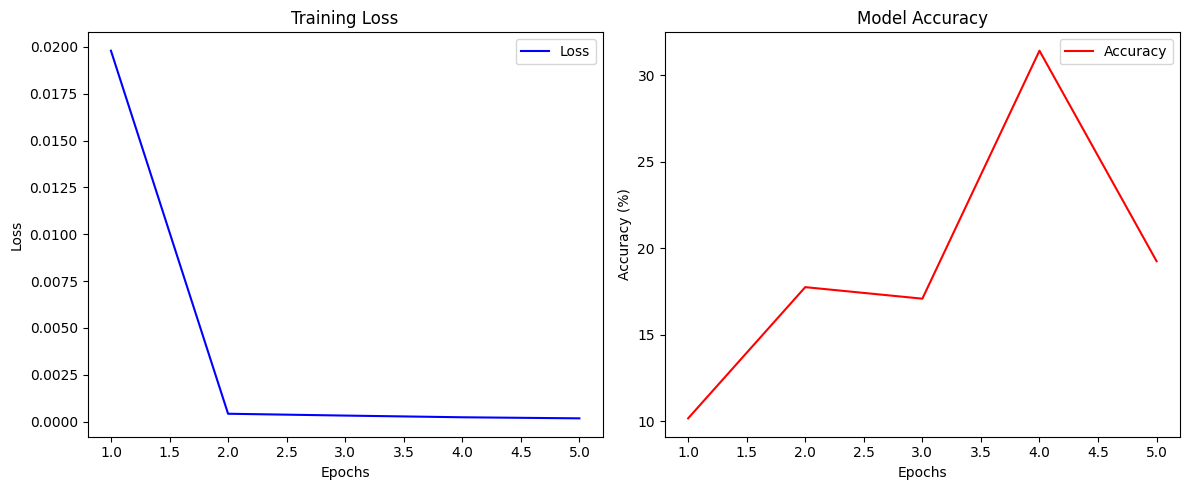

In [7]:
n_iters = 40
learning_rate = 0.001
batch_size = 32
threshold = 0.01

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
accuracy_values = []

for epoch in range(5):
    total_loss = 0
    model.train()  # Set the model to training mode
    for src, tgt, mask in dataloader:
        optimizer.zero_grad()
        output = model(src)
        masked_output = output  # output[:, 6, :]
        loss = loss_function(masked_output, tgt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f'Epoch {epoch+1}/{n_iters}, Loss: {avg_loss}')

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        t_src_data_tensor, t_tgt_data_tensor, t_src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
        print(t_tgt_data_tensor[2])
        predictions = model(t_src_data_tensor)
        print(predictions[2])
        accuracy = df.compute_accuracy(predictions, t_tgt_data_tensor, threshold=0.01)
        print(accuracy)
        accuracy_values.append(accuracy)
        print(f'Accuracy after Epoch {epoch+1}/{n_iters}: {accuracy:.2f}%')

# Plotting loss and accuracy
epochs = range(1, 5 + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'r', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
total_size = 4
max_x = 1000
max_y = 1000
min_x = 0
min_y = 0
track_len = 3

trajectories_test = dm.create_synthetic(total_size, max_x, max_y, min_x, min_y, track_len)
trajectories_test

ValueError: empty range in randrange(5, 4)

In [18]:
t_test_norm, min_x, min_y, range_x, range_y = nd.normalize_data(trajectories_test, min_x, min_y, range_x, range_y)
t_test_norm

[[(0.01705098308662502, 0.2597693178542398),
  (0.022981759812407635, 0.2597693178542398),
  (0.02891253653819025, 0.2597693178542398),
  (0.034843313263972865, 0.2597693178542398),
  (0.04077408998975548, 0.2597693178542398),
  (0.04670486671553809, 0.2597693178542398),
  (0.05263564344132071, 0.2597693178542398),
  (0.058566420167103325, 0.2597693178542398),
  (0.06449719689288594, 0.2597693178542398),
  (0.07042797361866855, 0.2597693178542398),
  (0.07635875034445117, 0.2597693178542398),
  (0.08228952707023378, 0.2597693178542398),
  (0.0882203037960164, 0.2597693178542398),
  (0.09415108052179902, 0.2597693178542398),
  (0.10008185724758163, 0.2597693178542398),
  (0.10601263397336425, 0.2597693178542398),
  (0.11194341069914686, 0.2597693178542398),
  (0.11787418742492947, 0.2597693178542398),
  (0.12380496415071209, 0.2597693178542398),
  (0.1297357408764947, 0.2597693178542398)],
 [(0.56119974767718, 0.4215684929748806),
  (0.5626824418586256, 0.4215684929748806),
  (0.5641651

In [19]:
t_test_unnorm = nd.unnormalize_data(t_test_norm, min_x, min_y, range_x, range_y)
t_test_unnorm

[[(23.0, 350.0),
  (31.000000000000004, 350.0),
  (39.0, 350.0),
  (47.0, 350.0),
  (55.0, 350.0),
  (63.0, 350.0),
  (71.0, 350.0),
  (79.0, 350.0),
  (87.0, 350.0),
  (95.0, 350.0),
  (103.0, 350.0),
  (110.99999999999999, 350.0),
  (119.00000000000001, 350.0),
  (127.0, 350.0),
  (135.0, 350.0),
  (143.0, 350.0),
  (151.0, 350.0),
  (159.0, 350.0),
  (167.0, 350.0),
  (175.0, 350.0)],
 [(757.0, 568.0),
  (759.0, 568.0),
  (761.0, 568.0),
  (763.0, 568.0),
  (764.9999999999999, 568.0),
  (767.0000000000001, 568.0),
  (769.0, 568.0),
  (771.0, 568.0),
  (773.0, 568.0),
  (775.0, 568.0),
  (777.0, 568.0),
  (779.0, 568.0),
  (781.0, 568.0),
  (783.0, 568.0),
  (784.9999999999999, 568.0),
  (787.0000000000001, 568.0),
  (789.0000000000001, 568.0),
  (791.0, 568.0),
  (793.0, 568.0),
  (795.0, 568.0)],
 [(258.0, 798.0000000000001),
  (261.0, 798.0000000000001),
  (264.0, 798.0000000000001),
  (267.0, 798.0000000000001),
  (270.0, 798.0000000000001),
  (273.0, 798.0000000000001),
  (276.0

In [30]:
def predict_single_trajectory(model, trajectory, device='cpu'):
    """
    Predicts the output for a single trajectory using the trained model.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        trajectory (any): The input trajectory data formatted as required by the model.
        device (str): The device to use ('cpu' or 'cuda').
    
    Returns:
        Any: The prediction made by the model.
    """
    model.eval()

    
    # Make prediction
    with torch.no_grad():
        predictions = model(trajectory)
    
    return predictions

In [42]:
test_data, test_masked_point = df.mask_point_at_index(t_test_norm, 6)
a, b, c = df.prepare_data_for_transformer(test_data, test_masked_point)
prediction = predict_single_trajectory(model, a)
prediction_list = prediction.tolist()
print("Prediction:", (prediction_list[0][0], prediction_list[0][1]))

hello
Prediction: (0.09124358743429184, 0.27071061730384827)


In [38]:
pred = nd.unnormalize_point((prediction_list[0][0], prediction_list[0][1]), min_x, min_y, range_x, range_y )

TypeError: can't multiply sequence by non-int of type 'float'